# Airflow 공부
#### 2022.08.08
***
## PythonOperator
***

Python 코드를 활용해 task 정의

airflow XCOM을 활용해 DAG task끼리 값을 주고 받음

### Airflow XCom(cross-communications)?
- airflow의 task는 독립적으로 수행된다. -> A task에서 나온 결과를 B task에 전달 할 수 없음
- task끼리 적은 양의 메시지를 주고 받을 수 있게 함.
- pandas의 dataframe과 같은 large value에는 적합하지 않음.
- task_id, dag_id, key로 구분 되어 있음.
- xcom_push와 xcom_pull을 이용해 storage에 push, pull

In [2]:
from datetime import datetime, timedelta
from textwrap import dedent

from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.dummy import DummyOperator
from airflow.operators.python import BranchPythonOperator
from airflow.operators.python_operator import PythonOperator
from airflow.utils.trigger_rule import TriggerRule

from random import randint

In [3]:
def which_path() :
    return 'Calculate_1' if randint(1, 2) == 1 else 'Calculate_2'

위의 코드는 랜덤하게 정수(1 혹은 2)를 받아 분기 지점을 반환한다.

In [4]:
dag_args = {'dag_id' : 'BRANCH_DAG', 'start_date' : datetime(2022, 8, 8)}

In [5]:
def calculate_add(x, y, **kwargs) :
    
    result = x + y
    print(f"x + y = {result}")
    kwargs['task_instance'].xcom_push(key = 'calculate_add_result', value = result)

In [6]:
def calculate_mul(x, y, **kwargs) :
    
    result = x * y
    print(f"x * y = {result}")
    kwargs['task_instance'].xcom_push(key = 'calculate_mul_result', value = result)

In [7]:
def print_result(**kwargs) :
    
    r = kwargs['task_instance'].xcom_pull(key = 'calculate_result')
    print(f"Message : {r}")
    print("*" * 50)
    print(kwargs)

In [8]:
def end_seq() :
    print("End")

In [11]:
with DAG(**dag_args) as dag :
    
    start = BashOperator(task_id = 'Start', bash_command = 'echo "Start!"')
    
    branch = BranchPythonOperator(task_id = 'branch', python_callable = which_path)
    
    calc_add = PythonOperator(task_id = 'Calc_add_id', python_callable = calculate_add, op_kwargs = {'x' : 10, 'y' : 4})
    
    calc_mul = PythonOperator(task_id = 'Calc_mul_id', python_callable = calculate_mul, op_kwargs = {'x' : 10, 'y' : 4})
    
    message = PythonOperator(task_id = 'Message', python_callable = print_result, trigger_rule = TriggerRule.NONE_FAILED)
    
    complete_py = PythonOperator(task_id = 'Complete_PO', python_callable = end_seq, trigger_rule = TriggerRule.NONE_FAILED)
    
    complete = BashOperator(task_id = 'Complete_Bash', depends_on_past = False, bash_command = 'echo "Complete!"', trigger_rule = TriggerRule.NONE_FAILED)
    
    start >> branch >> calc_add >> message >> complete_py >> complete
    start >> branch >> calc_mul >> message >> complete


***
참고 출처 : https://lsjsj92.tistory.com/632

In [2]:
from IPython.display import Image

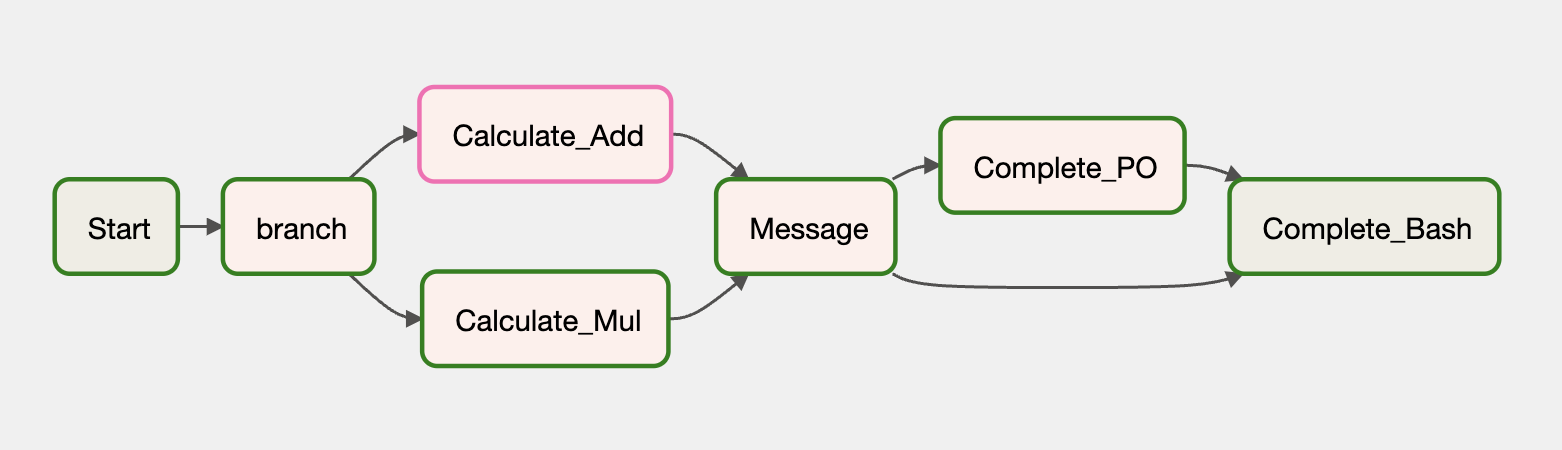

In [3]:
Image('./DAG_PO.png')